In [1]:
from Preprocess import *
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,precision_recall_fscore_support,classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Logistic Regression

### Get preprocessing dataframe

In [2]:
X_lr, Y_lr = get_data('diabetic_data.csv',labelEncode=False,dummy=True,skewness=True,standardize=False,diag_group=True)
pd.set_option('display.max_columns', 50)
X_lr.head()

Original data shape (101766, 50)
Process Missing data
Delete multipule encounters
Transform features
Reduce skewness
Dummify variables and drop the most frequent category
Data shape after preprocessing: (69973, 214)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,race_Hispanic,race_Missing,race_Other,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[80-90),age_[90-100),admission_type_id_2,...,diabetesMed_No,diag_1_group_Digestive,diag_1_group_Genitourinary,diag_1_group_Injury,diag_1_group_Missing,diag_1_group_Musculoskeletal,diag_1_group_Neoplasms,diag_1_group_Other,diag_1_group_Respiratory,diag_2_group_Digestive,diag_2_group_Genitourinary,diag_2_group_Injury,diag_2_group_Missing,diag_2_group_Musculoskeletal,diag_2_group_Neoplasms,diag_2_group_Other,diag_2_group_Respiratory,diag_3_group_Digestive,diag_3_group_Genitourinary,diag_3_group_Injury,diag_3_group_Missing,diag_3_group_Musculoskeletal,diag_3_group_Neoplasms,diag_3_group_Other,diag_3_group_Respiratory
0,2.219537,77,2.186540,5.547870,0.0,0.0,0.0,8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1.104172,49,0.722179,3.398773,0.0,0.0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,1.621388,68,1.172732,4.768542,0.0,0.0,0.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,1.395154,46,0.000000,4.486635,0.0,0.0,0.0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.806578,49,0.000000,2.239054,0.0,0.0,0.0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


### Train test split

In [3]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = ms.train_test_split(X_lr, Y_lr,test_size=0.2, random_state=0)
print('Readmission ratio for processed data : {}'.format(len(Y_lr[Y_lr==1])/len(Y_lr)))
print('Readmission ratio for training data and data size: {}, {}'\
      .format(len(y_train_lr[y_train_lr==1])/len(y_train_lr),len(y_train_lr)))
print('Readmission ratio for test data and data size: {}, {}'\
      .format(len(y_test_lr[y_test_lr==1])/len(y_test_lr),len(y_test_lr)))

Readmission ratio for processed data : 0.08970602946850928
Readmission ratio for training data and data size: 0.08964235949837436, 55978
Readmission ratio for test data and data size: 0.08996070025008931, 13995


### Resampling — Oversample minority class

In [4]:
# Concatenate training data back together
X_up = pd.concat([x_train_lr, y_train_lr], axis=1)

# separate minority and majority classes
not_readmitted = X_up[X_up.readmitted==0]
readmitted = X_up[X_up.readmitted==1]

# upsample minority
readmit_upsampled = resample(readmitted,
                             replace=True, # sample with replacement
                             n_samples=int(1*len(not_readmitted)), # match number in majority class
                             random_state=1) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_readmitted, readmit_upsampled])

# check new class counts
print(upsampled.readmitted.value_counts())

y_train_up = upsampled['readmitted']
x_train_up = upsampled.drop('readmitted',1)

1    50960
0    50960
Name: readmitted, dtype: int64


### Synthetic Minority Oversampling Technique (SMOTE)

In [5]:
smo = SMOTE(random_state=1, ratio=1)
x_train_smo, y_train_smo = smo.fit_sample(x_train_lr, y_train_lr)

# check new class counts
print(pd.Series(y_train_smo).value_counts())

1    50960
0    50960
dtype: int64


In [6]:
from sklearn.linear_model import LogisticRegression
LR_up = LogisticRegression(class_weight='balanced')
LR_smo = LogisticRegression(class_weight='balanced')
LR_up.fit(x_train_up, y_train_up)
y_predict_up = LR_up.predict(x_test_lr)
LR_smo.fit(x_train_smo, y_train_smo)
y_predict_smo = LR_smo.predict(x_test_lr)
print('Train score use over-sampling: {}'.format(LR_up.score(x_train_up, y_train_up)))
print('Test score use over-sampling: {}'.format(LR_up.score(x_test_lr, y_test_lr)))
print('Train score use SMOTE: {}'.format(LR_smo.score(x_train_smo, y_train_smo)))
print('Test score use SMOTE: {}'.format(LR_smo.score(x_test_lr, y_test_lr)))

Train score use over-sampling: 0.6132358712715855
Test score use over-sampling: 0.6563058235083958
Train score use SMOTE: 0.636734693877551
Test score use SMOTE: 0.6382993926402286


In [7]:
confusion_matrix(y_test_lr,y_predict_up)

array([[8485, 4251],
       [ 559,  700]])

In [8]:
confusion_matrix(y_test_lr,y_predict_smo)

array([[8242, 4494],
       [ 568,  691]])

In [9]:
print(classification_report(y_test_lr,y_predict_smo))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     12736
           1       0.13      0.55      0.21      1259

    accuracy                           0.64     13995
   macro avg       0.53      0.60      0.49     13995
weighted avg       0.86      0.64      0.72     13995



### K-fold

In [10]:
LR_up.set_params(C=1e1,penalty='l2')
LR_smo.set_params(C=1e1,penalty='l2')
stratify_divide = ms.StratifiedKFold(n_splits=5, random_state=0)
scores_up = ms.cross_val_score(estimator=LR_up, X=x_train_up, y=y_train_up, cv=stratify_divide)
scores_smo = ms.cross_val_score(estimator=LR_smo, X=x_train_smo, y=y_train_smo, cv=stratify_divide)
print('Train score use over-sampling: {}'.format(scores_up.mean()))
print('Train score use SMOTE: {}'.format(scores_smo.mean()))

Train score use over-sampling: 0.6099784144427002
Train score use SMOTE: 0.6348214285714286


In [11]:
LR_up.set_params(C=1e1,penalty='l1')
LR_smo.set_params(C=1e1,penalty='l1')
stratify_divide = ms.StratifiedKFold(n_splits=9, random_state=0)
scores_up = ms.cross_val_score(estimator=LR_up, X=x_train_up, y=y_train_up, cv=stratify_divide)
scores_smo = ms.cross_val_score(estimator=LR_smo, X=x_train_smo, y=y_train_smo, cv=stratify_divide)
print('Train score use over-sampling: {}'.format(scores_up.mean()))
print('Train score use SMOTE: {}'.format(scores_smo.mean()))

Train score use over-sampling: 0.6108714179183978
Train score use SMOTE: 0.6351654827497727


In [12]:
pd.DataFrame(LR_smo.coef_[0],index=x_train_lr.columns,columns=['Coef_value'])\
    .sort_values('Coef_value',ascending=False).head(5)

,Coef_value
discharge_disposition_id_15,2.516074
discharge_disposition_id_28,1.757489
discharge_disposition_id_22,1.631602
discharge_disposition_id_9,1.314041
discharge_disposition_id_5,1.255499


In [13]:
pd.DataFrame(LR_smo.coef_[0],index=x_train_lr.columns,columns=['Coef_value'])\
    .sort_values('Coef_value',ascending=True).head(5)

,Coef_value
medical_specialty_Pediatrics-Endocrinology,-2.783026
medical_specialty_Gynecology,-2.217509
tolbutamide_Steady,-2.215466
admission_type_id_7,-1.968243
rosiglitazone_Down,-1.939586


In [14]:
quan_table_lr = quan_tab(LR_smo,x_test_lr,y_test_lr)
quan_table_lr.sort_values('quantile',ascending=False)

,quantile,amount,readmitted,min,max,pct_readmitted,lift
9,10,1400,289,0.673576,0.976762,0.206429,2.294690
8,9,1399,175,0.592176,0.673559,0.125089,1.390511
7,8,1400,121,0.535185,0.592157,0.086429,0.960752
6,7,1399,140,0.487212,0.535166,0.100071,1.112409
5,6,1399,110,0.443232,0.487202,0.078628,0.874036
4,5,1400,97,0.402397,0.443213,0.069286,0.770190
3,4,1399,102,0.360360,0.402354,0.072909,0.810469
2,3,1400,91,0.313149,0.360359,0.065000,0.722549
1,2,1399,74,0.252303,0.313123,0.052895,0.587988
0,1,1400,60,0.011852,0.252247,0.042857,0.476406


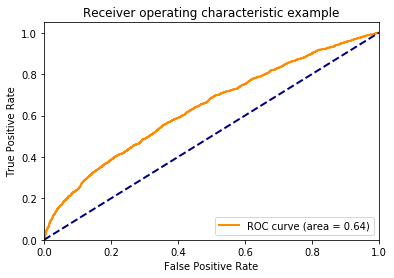

In [15]:
y_probs_lr = pd.DataFrame(LR_smo.predict_proba(x_test_lr))[1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_probs_lr)
auc_lr = roc_auc_score(y_test_lr, y_probs_lr)
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Random forest and XGBoost

### Get preprocessing dataframe for Random Forest and XGBoost

In [16]:
# Random forest & XGB
X, Y = get_data('diabetic_data.csv',labelEncode=True,dummy=False,skewness=False, standardize = True,diag_group=False)

Original data shape (101766, 50)
Process Missing data
Delete multipule encounters
Transform features
Standardize numeric columns
Conduce label encoding
Data shape after preprocessing: (69973, 43)


In [17]:
x_train, x_test, y_train, y_test = ms.train_test_split(X, Y,test_size=0.2, random_state=0)
print('Readmission ratio for processed data : {}'.format(len(Y[Y==1])/len(Y)))
print('Readmission ratio for training data and data size: {}, {}'\
      .format(len(y_train[y_train==1])/len(y_train),len(y_train)))
print('Readmission ratio for test data and data size: {}, {}'\
      .format(len(y_test[y_test==1])/len(y_test),len(y_test)))
x_train_o = x_train
x_test_o = x_test
y_train_o = y_train
y_test_o = y_test

Readmission ratio for processed data : 0.08970602946850928
Readmission ratio for training data and data size: 0.08964235949837436, 55978
Readmission ratio for test data and data size: 0.08996070025008931, 13995


### Resampling techniques — Undersample majority class

In [18]:
# Concatenate training data back together
X_down = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
not_readmitted = X_down[X_down.readmitted==0]
readmitted = X_down[X_down.readmitted==1]

# downsample majority
not_readmit_downsampled = resample(not_readmitted,
                                     replace = False, # sample without replacement
                                     n_samples = int(1*len(readmitted)), # match minority n
                                     random_state = 1) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_readmit_downsampled, readmitted])

# checking counts
print(downsampled.readmitted.value_counts())

y_train_down = downsampled['readmitted']
x_train_down = downsampled.drop('readmitted',1)

1    5018
0    5018
Name: readmitted, dtype: int64


# Random Forest

In [19]:
X_train = x_train_down
y_train = y_train_down
X_test = x_test
func, para = rfc_optimization(X_train,y_train,5)

In [20]:
rf_opt = rfc_train(X_train, y_train, X_test, y_test, func, para)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.6376   |  8.577    |  7.187    |  794.8    |
|  2        |  0.6359   |  106.4    |  7.939    |  724.6    |
|  3        |  0.638    |  19.72    |  6.808    |  503.3    |
|  4        |  0.6362   |  126.3    |  7.045    |  967.4    |
|  5        |  0.6332   |  98.24    |  6.873    |  148.7    |
|  6        |  0.6053   |  1.05     |  9.949    |  10.47    |
|  7        |  0.6331   |  147.4    |  2.293    |  998.7    |
|  8        |  0.621    |  1.792    |  5.356    |  999.8    |
|  9        |  0.6374   |  147.0    |  9.97     |  999.8    |
|  10       |  0.6361   |  146.0    |  7.655    |  1e+03    |


In [21]:
y_pr_rf = rf_opt.predict(x_test)
print('Train score: {}'.format(rf_opt.score(X_train, y_train)))
print('Test score: {}'.format(rf_opt.score(x_test, y_test)))

Train score: 0.9810681546432842
Test score: 0.6003572704537334


In [22]:
confusion_matrix(y_test,y_pr_rf)

array([[7597, 5139],
       [ 454,  805]])

<Figure size 720x576 with 0 Axes>

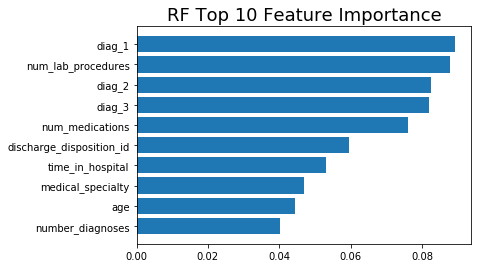

<Figure size 720x576 with 0 Axes>

In [23]:
sorted_importance_rf = sorted(zip(x_test.columns, rf_opt.feature_importances_), key=lambda t:t[1], reverse=True)
plt.barh([x[0] for x in sorted_importance_rf[:10]][::-1],[x[1] for x in sorted_importance_rf[:10]][::-1])
plt.title('RF Top 10 Feature Importance', fontsize=18)
plt.figure(figsize=(10,8))

In [24]:
precision_recall_fscore_support(y_test,y_pr_rf)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.94360949, 0.13543069]),
 array([0.59649812, 0.63939635]),
 array([0.73093761, 0.22351798]),
 array([12736,  1259]))

In [25]:
quantile_table_RF = quan_tab(rf_opt,x_test,y_test)
quantile_table_RF

,quantile,amount,readmitted,min,max,pct_readmitted,lift
0,1,1400,49,0.084376,0.338649,0.035000,0.389063
1,2,1399,57,0.338714,0.382255,0.040743,0.452907
2,3,1400,77,0.382259,0.415823,0.055000,0.611384
3,4,1399,102,0.415900,0.446824,0.072909,0.810465
4,5,1400,80,0.446830,0.476334,0.057143,0.635205
5,6,1399,127,0.476375,0.506939,0.090779,1.009108
6,7,1399,142,0.506952,0.538496,0.101501,1.128294
7,8,1400,167,0.538529,0.573337,0.119286,1.325990
8,9,1399,183,0.573400,0.616820,0.130808,1.454069
9,10,1400,275,0.616838,0.850367,0.196429,2.183516


In [26]:
print(classification_report(y_test,y_pr_rf))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73     12736
           1       0.14      0.64      0.22      1259

    accuracy                           0.60     13995
   macro avg       0.54      0.62      0.48     13995
weighted avg       0.87      0.60      0.69     13995



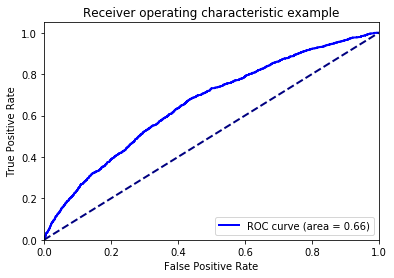

In [27]:
y_probs_rf = pd.DataFrame(rf_opt.predict_proba(x_test))[1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)
auc_rf = roc_auc_score(y_test, y_probs_rf)
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='blue', lw=lw, label='ROC curve (area = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# XGB

In [28]:
X_train = x_train_down
y_train = y_train_down
X_train, val_x, y_train, val_y = ms.train_test_split(X_train, y_train, test_size = 0.05, random_state=1)
X_train = x_train_down
y_train = y_train_down
X_test = x_test
func, para = xgb_optimization(X_train,y_train,5,[[val_x, val_y]])
dataset = (X_train, y_train, X_test, y_test)
cv_splits = 5

In [29]:
best_solution = bayesian_optimization(dataset, func, para)      
params = best_solution["params"]

|   iter    |  target   |    eta    |   gamma   | max_depth |
-------------------------------------------------------------
|  1        |  0.6111   |  0.3437   |  6.146    |  1.924e+0 |
|  2        |  0.6378   |  0.03228  |  5.89     |  757.8    |
|  3        |  0.632    |  0.1111   |  12.04    |  1.674e+0 |
|  4        |  0.6361   |  0.1973   |  10.18    |  1.201e+0 |
|  5        |  0.6317   |  0.09432  |  12.92    |  1.864e+0 |
|  6        |  0.6212   |  0.2173   |  14.47    |  1.005    |
|  7        |  0.6214   |  0.1996   |  0.3068   |  1.02     |
|  8        |  0.6262   |  0.2426   |  19.32    |  2e+03    |
|  9        |  0.6025   |  0.05769  |  19.88    |  1.103    |
|  10       |  0.607    |  0.2025   |  0.2639   |  2e+03    |


In [30]:
xgb_opt = xgb.XGBClassifier(
             eta=max(params["eta"], 0),
             gamma=max(params["gamma"], 0),
             max_depth=int(max(params["max_depth"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

In [31]:
X_train = x_train_down
y_train = y_train_down
xgb_opt.fit(x_train_down, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.03227885153143598, gamma=5.890057380522387,
              learning_rate=0.1, max_delta_step=0, max_depth=757,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
y_pr_xgb = xgb_opt.predict(x_test)
print('Train score: {}'.format(xgb_opt.score(x_train_o, y_train_o)))
print('Test score use: {}'.format(xgb_opt.score(x_test_o, y_test_o)))

Train score: 0.6569545178462968
Test score use: 0.6095033940693104


In [33]:
confusion_matrix(y_test,y_pr_xgb)

array([[7758, 4978],
       [ 487,  772]])

<Figure size 720x576 with 0 Axes>

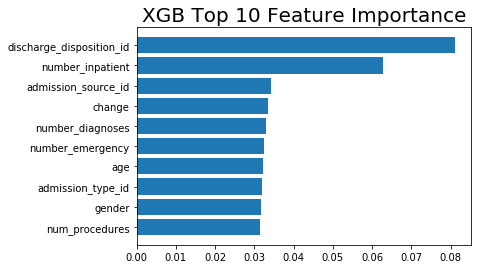

<Figure size 720x576 with 0 Axes>

In [34]:
sorted_importance_xgb = sorted(zip(x_test.columns, xgb_opt.feature_importances_), key=lambda t:t[1], reverse=True)
plt.barh([x[0] for x in sorted_importance_xgb[:10]][::-1],[x[1] for x in sorted_importance_xgb[:10]][::-1])
plt.title('XGB Top 10 Feature Importance', fontsize=20)
plt.figure(figsize=(10,8))

In [35]:
precision_recall_fscore_support(y_test,y_pr_xgb)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.9409339 , 0.13426087]),
 array([0.60913945, 0.61318507]),
 array([0.73952624, 0.2202882 ]),
 array([12736,  1259]))

In [36]:
quantile_table_xgb = quan_tab(xgb_opt,x_test,y_test)
quantile_table_xgb

,quantile,amount,readmitted,min,max,pct_readmitted,lift
0,1,1400,42,0.056830,0.237567,0.030000,0.333481
1,2,1399,73,0.237604,0.302694,0.052180,0.580036
2,3,1400,73,0.302742,0.356721,0.052143,0.579622
3,4,1399,87,0.356728,0.405701,0.062187,0.691276
4,5,1400,108,0.405733,0.454590,0.077143,0.857522
5,6,1399,123,0.454629,0.505243,0.087920,0.977321
6,7,1399,151,0.505243,0.559841,0.107934,1.199800
7,8,1400,139,0.559857,0.621307,0.099286,1.103663
8,9,1399,185,0.621322,0.704851,0.132237,1.469954
9,10,1400,278,0.704860,0.966880,0.198571,2.207326


In [37]:
print(classification_report(y_test,y_pr_xgb))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74     12736
           1       0.13      0.61      0.22      1259

    accuracy                           0.61     13995
   macro avg       0.54      0.61      0.48     13995
weighted avg       0.87      0.61      0.69     13995



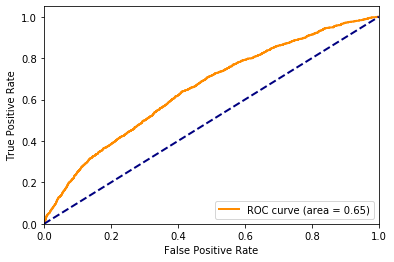

In [38]:
y_probs_xgb = pd.DataFrame(xgb_opt.predict_proba(x_test))[1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)
auc_xgb = roc_auc_score(y_test, y_probs_xgb)
plt.figure()
lw = 2
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ROC Curve

In [39]:
lbl = LabelEncoder() 
lbl.fit(list(y_test.values)) 
y_test = lbl.transform(list(y_test.values))

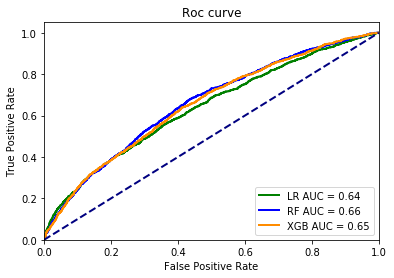

In [40]:
# y_probs = pd.DataFrame(LR_up.predict_proba(x_test))[1]
# fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# auc = roc_auc_score(y_test, y_probs)
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='green', lw=lw, label='LR AUC = %0.2f' % auc_lr)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=lw, label='RF AUC = %0.2f' % auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='XGB AUC = %0.2f' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.legend(loc="lower right")
plt.show()